In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from mmcontext.file_utils import setup_logging

setup_logging()

mmcontext.utils - INFO - mmcontext logging configured using the specified configuration file.


### Inference
By providing a path to an anndata file we can use a pre-trained model to infer embedding for both omics and captions. These will be stored in adata.obs["omics_emb"] and adata.obs["caption_emb"]

In [40]:
model_path = "../../data/models/trained_mmcontext_model_large_cellxgene"
test_path = "../../data/raw/test/small_adata_test.h5ad"

In [41]:
import anndata
import scanpy as sc
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(model_path)
embedding_dim = model[0].model.omics_encoder._get_sentence_embedding_dimension()
adata_test = anndata.read_h5ad(test_path)

sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: ../../data/models/trained_mmcontext_model_large_cellxgene


In [42]:
from mmcontext.pp import InitialEmbedder

init_embedder = InitialEmbedder(embedding_dim=embedding_dim, precomputed_key="scvi")
init_embedder.embed(adata_test)

mmcontext.pp.initial_embedder - INFO - Using precomputed embeddings. Copying from adata.obsm['scvi'] to adata.obsm['X_pp']


In [43]:
adata_test.obsm["scvi"]

array([[-1.17492676e-03,  5.27954102e-03, -1.25000000e+00, ...,
        -4.85229492e-03, -1.03149414e-02,  1.62506104e-03],
       [ 3.67736816e-03,  1.29394531e-02, -1.63281250e+00, ...,
        -8.85009766e-04,  5.82885742e-03,  2.48718262e-03],
       [ 6.56127930e-03,  3.14331055e-03, -2.92968750e-01, ...,
        -3.37219238e-03,  5.64575195e-03,  1.15356445e-02],
       ...,
       [ 3.03649902e-03, -4.54711914e-03,  2.42187500e+00, ...,
         2.91824341e-04, -1.03149414e-02,  3.93676758e-03],
       [-3.12805176e-03, -4.63867188e-03, -2.20312500e+00, ...,
         2.89916992e-03,  8.97216797e-03, -3.50952148e-03],
       [ 2.94494629e-03,  1.02539062e-02, -2.00000000e+00, ...,
         6.22558594e-03,  1.10473633e-02,  5.31005859e-03]], dtype=float32)

In [44]:
adata_test.write_h5ad(test_path)

In [45]:
from mmcontext.infer import MMContextInference
from mmcontext.pp import AnnDataSetConstructor
from mmcontext.pp.caption_constructors import SimpleCaptionConstructor

# Create caption constructor with desired obs keys
caption_constructor = SimpleCaptionConstructor(obs_keys=["cell_type"])
constructor = AnnDataSetConstructor(caption_constructor=caption_constructor)
inferer = MMContextInference(file_path=test_path, constructor=constructor, model=model)
adata_new = inferer.encode(batch_size=128)

mmcontext.pp.AnnDataDataSetConstructor - INFO - Successfully added anndata file: ../../data/raw/test/small_adata_test.h5ad
mmcontext.pp.AnnDataDataSetConstructor - INFO - Building caption for inference from file: ../../data/raw/test/small_adata_test.h5ad


... storing 'caption' as categorical


mmcontext.pp.AnnDataDataSetConstructor - INFO - Retrieving captions for inference from file: ../../data/raw/test/small_adata_test.h5ad
mmcontext.pp.AnnDataDataSetConstructor - INFO - Constructed inference dataset with 1000 samples.
mmcontext.infer - INFO - Sample order verification successful
mmcontext.infer - INFO - Computing embeddings for omics data...


Batches: 100%|██████████| 32/32 [00:00<00:00, 74.81it/s]

mmcontext.infer - INFO - Computing embeddings for captions...



Batches: 100%|██████████| 32/32 [00:00<00:00, 121.12it/s]

mmcontext.infer - INFO - Added embeddings to .obsm: omics_emb (1000, 50), caption_emb (1000, 50)


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='omics_emb'.


<Figure size 800x800 with 0 Axes>

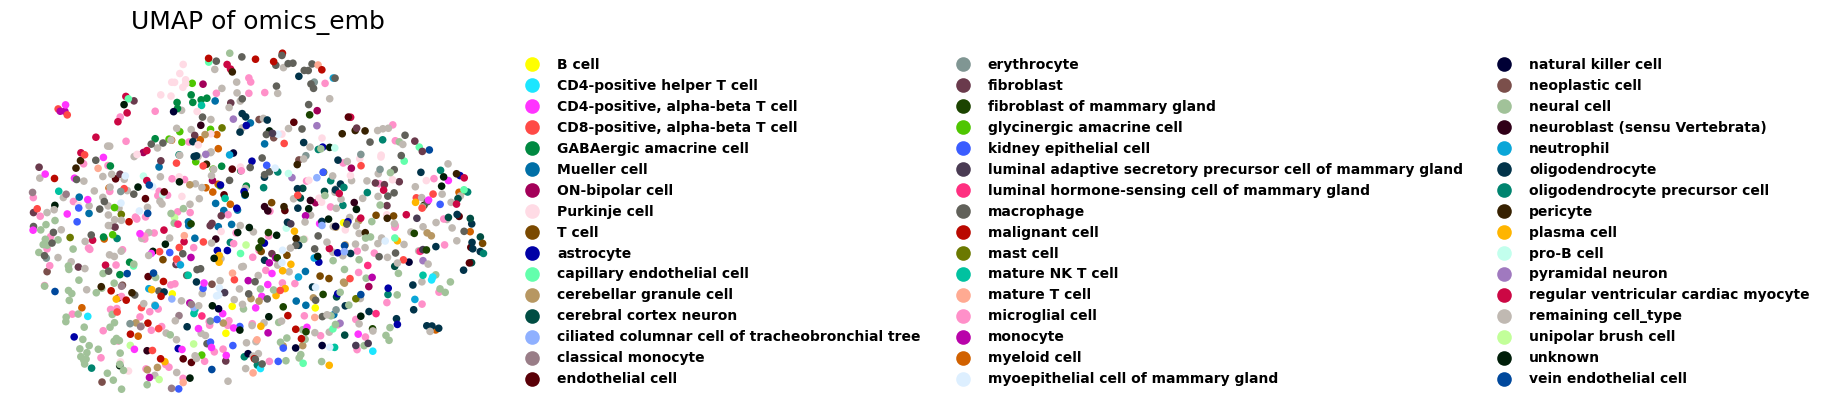

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [46]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata_new, color_key="cell_type", embedding_key="omics_emb", sample_size=5000)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='caption_emb'.


/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The e

<Figure size 800x800 with 0 Axes>

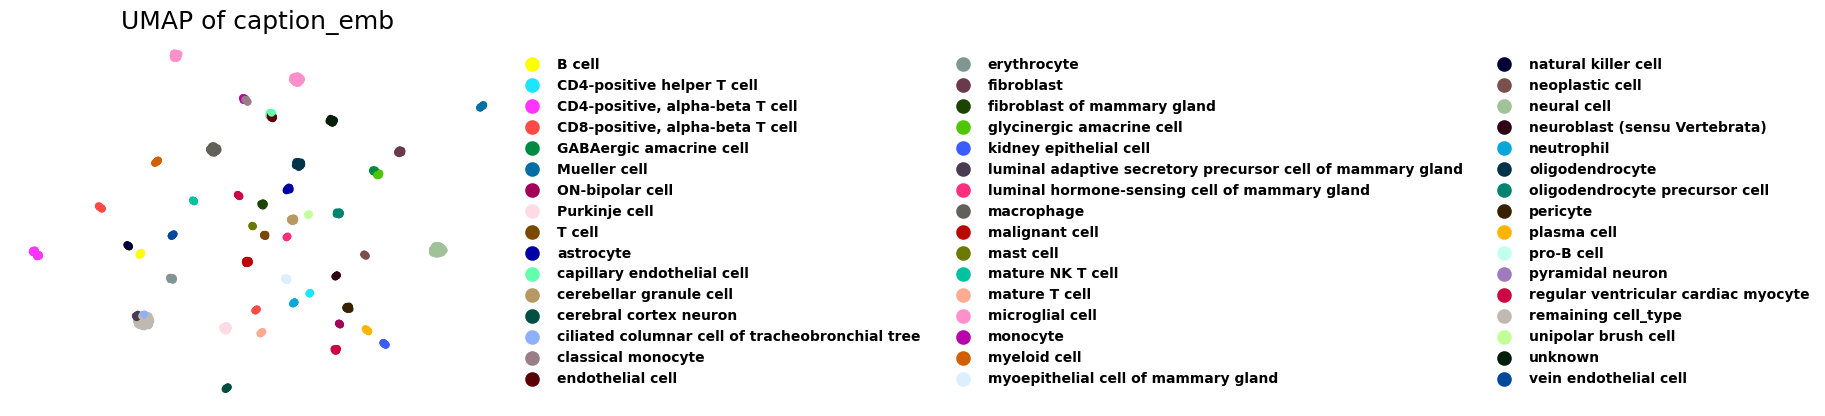

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [47]:
plot_umap(adata_new, color_key="cell_type", embedding_key="caption_emb")

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_pp'.


<Figure size 800x800 with 0 Axes>

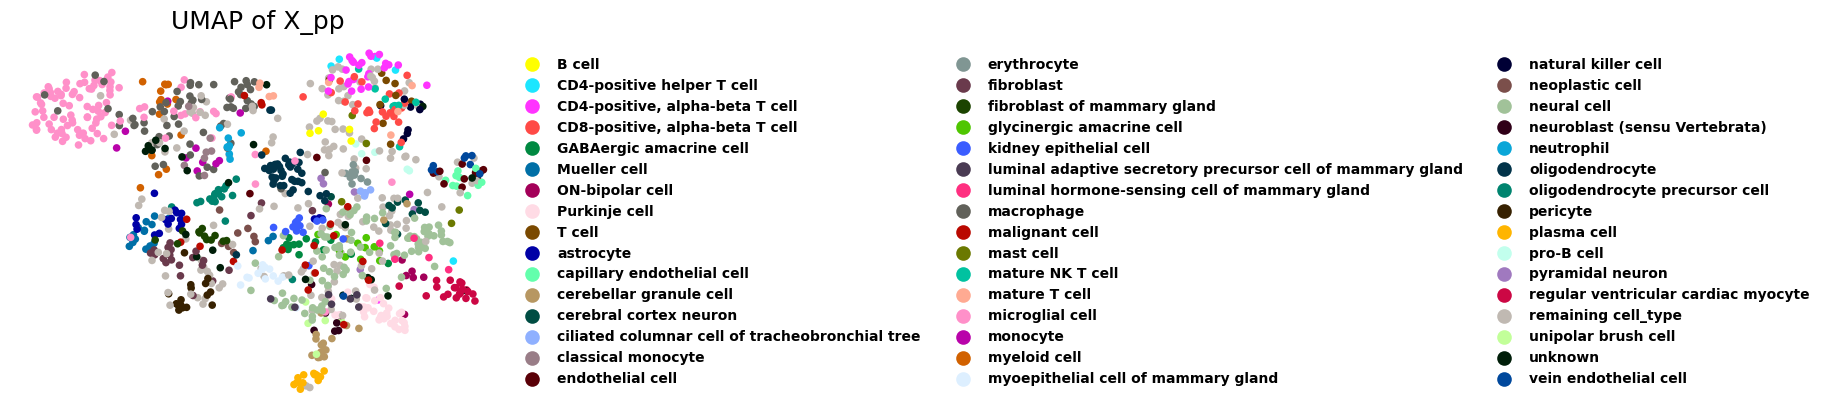

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [48]:
plot_umap(adata_new, color_key="cell_type", embedding_key="X_pp")

### Annotation of dataset

In [19]:
from mmcontext.engine import OmicsQueryAnnotator

# we start simple by using only the cell types present in the test dataset
cell_types = list(adata_test.obs["cell_type"].unique())
qa = OmicsQueryAnnotator(model=model)
qa.annotate_omics_data(adata_new, labels=cell_types)

mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.


Batches: 100%|██████████| 2/2 [00:00<00:00, 20.90it/s]

mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
mmcontext.utils - INFO - Performing matrix multiplication on device=cpu


In [20]:
adata_new.obs["inferred_labels"].values

array([{'neoplastic cell': 0.8789359331130981, 'myeloid cell': 0.6073119044303894, 'oligodendrocyte precursor cell': 0.49358248710632324, 'astrocyte': 0.8007648587226868, 'remaining cell_type': 0.7548410892486572, 'macrophage': 0.5268068909645081, 'microglial cell': 0.33786895871162415, 'pro-B cell': 0.13296175003051758, 'GABAergic amacrine cell': 0.4437963664531708, 'glycinergic amacrine cell': 0.4904365539550781, 'fibroblast': 0.702343225479126, 'plasma cell': 0.18175210058689117, 'ON-bipolar cell': 0.1374407261610031, 'Mueller cell': 0.7614036202430725, 'pericyte': 0.5787275433540344, 'natural killer cell': 0.25605013966560364, 'mature NK T cell': 0.3224075436592102, 'CD4-positive, alpha-beta T cell': 0.4004315733909607, 'B cell': 0.029882527887821198, 'T cell': 0.36244168877601624, 'endothelial cell': 0.6904617547988892, 'CD8-positive, alpha-beta T cell': 0.3197018802165985, 'kidney epithelial cell': 0.6676335334777832, 'cerebral cortex neuron': 0.2789391577243805, 'pyramidal neuro

In [21]:
from mmcontext.eval.annotation_accuracy import evaluate_annotation_accuracy

evaluate_annotation_accuracy(adata_new, true_key="cell_type", inferred_key="best_label")

ModuleNotFoundError: No module named 'mmcontext.eval.annotation_accuracy'

In [13]:
qa.query_with_text(adata_new, ["B-Cell", "macrophage"])

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 36306 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

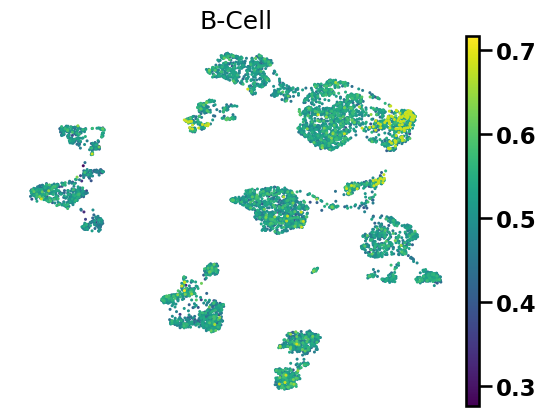

<Figure size 800x800 with 0 Axes>

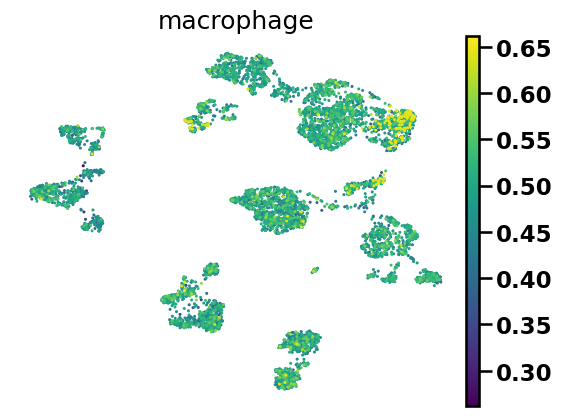

In [14]:
from mmcontext.pl import plot_query_scores_umap

plot_query_scores_umap(adata_new)

In [35]:
# was useful with accelerate import error
import importlib

import transformers.utils.import_utils

importlib.reload(transformers.trainer_pt_utils)

<module 'transformers.trainer_pt_utils' from '/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/transformers/trainer_pt_utils.py'>

In [36]:
from transformers.utils import is_accelerate_available

is_accelerate_available()

True